# RO47019: Intelligent Control Systems Practical Assignment
* Period: 2023-2024, Q3
* Course homepage: https://brightspace.tudelft.nl/d2l/home/500969
* Instructor: Cosimo Della Santina (C.DellaSantina@tudelft.nl)
* Teaching assistant: Maria de Neves de Fonseca (M.deNevesdeFonseca-1@student.tudelft.nl)
* (c) TU Delft, 2024

Make sure you fill in any place that says `YOUR CODE HERE` or `YOUR ANSWER HERE`. Remove `raise NotImplementedError()` afterwards. Moreover, if you see an empty cell, please DO NOT delete it, instead run that cell as you would run all other cells. Please fill in your name(s) and other required details below:

In [1]:
# Please fill in your names, student numbers, netID, and emails below.
STUDENT_1_NAME = "Zhengyang Lu"
STUDENT_1_STUDENT_NUMBER = "5074428"
STUDENT_1_NETID = "zhengyanglu"
STUDENT_1_EMAIL = "Z.lu-5@student.tudelft.nl"

In [2]:
# Note: this block is a check that you have filled in the above information.
# It will throw an AssertionError until all fields are filled
assert STUDENT_1_NAME != ""
assert STUDENT_1_STUDENT_NUMBER != ""
assert STUDENT_1_NETID != ""
assert STUDENT_1_EMAIL != ""

### General announcements

* Do *not* share your solutions (also after the course is finished), and do *not* copy solutions from others. By submitting your solutions, you claim that you alone are responsible for this code.

* Do *not* email questions directly, since we want to provide everybody with the same information and avoid repeating the same answers. Instead, please post your questions regarding this assignment in the correct support forum on Brightspace, this way everybody can benefit from the response. If you do have a particular question that you want to ask directly, please use the scheduled Q&A hours to ask the TA.

* There is a strict deadline for each assignment. Students are responsible to ensure that they have uploaded their work in time. So, please double check that your upload succeeded to the Brightspace and avoid any late penalties.

* This [Jupyter notebook](https://jupyter.org/) uses `nbgrader` to help us with automated tests. `nbgrader` will make various cells in this notebook "uneditable" or "unremovable" and gives them a special id in the cell metadata. This way, when we run our checks, the system will check the existence of the cell ids and verify the number of points and which checks must be run. While there are ways that you can edit the metadata and work around the restrictions to delete or modify these special cells, you should not do that since then our nbgrader backend will not be able to parse your notebook and give you points for the assignment. You are free to add additional cells, but if you find a cell that you cannot modify or remove, please know that this is on purpose.

* This notebook will have in various places a line that throws a `NotImplementedError` exception. These are locations where the assignment requires you to adapt the code! These lines are just there as a reminder for you that you have not yet adapted that particular piece of code, especially when you execute all the cells. Once your solution code replaced these lines, it should accordingly *not* throw any exceptions anymore.

Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

# Task 2d.3 - Q-ILC (17.5p)

**Author:** Maximilian Stölzle (M.W.Stolzle@tudelft.nl)

We assume the scenario as in Task 2d.2, but now use Q-ILC instead of PD-ILC. This means, that we leverage LQR to compute the optimal gains $L_\mathrm{opt}$, instead of manually tuning the proportional and derivative gains used within the ILC learning rule.

In [3]:
# Reloads the python files outside of this notebook automatically
%load_ext autoreload
%autoreload 2

from distutils.util import strtobool
from functools import partial
from IPython.display import display, HTML  # For animations in the notebook
from jax import config as jax_config

jax_config.update("jax_platform_name", "cpu")  # set default device to 'cpu'
jax_config.update("jax_enable_x64", True)  # double precision
from jax import Array, jit, lax, vmap
import jax.numpy as jnp
import os
from pathlib import Path
from typing import Callable, Dict, Tuple

from jax_double_pendulum.motion_planning import (
    generate_ellipse_trajectory,
    ELLIPSE_PARAMS,
)
from jax_double_pendulum.robot_parameters import ROBOT_PARAMS

from ilc import init_ilc_its, apply_ilc_control_action_to_system

# import linearize_closed_loop_fb_system_about_trajectory from linearization.ipynb
from ipynb.fs.full.linearization import cont2discrete_zoh

# import linearize_closed_loop_fb_system_about_trajectory from linearization.ipynb
from ipynb.fs.full.linearization import linearize_closed_loop_fb_system_about_trajectory

# define boolean to check if the notebook is run for the purposes of autograding
AUTOGRADING = strtobool(os.environ.get("AUTOGRADING", "false"))
# define tolerances for grading
RTOL = float(os.environ.get("RTOL", "1e-4"))  # relative tolerance
ATOL = float(os.environ.get("ATOL", "1e-7"))  # absolute tolerance

## Lifted system input to state mapping (5p)

The goal of this task is to compute the matrix $P \in \mathbb{R}^{2 (N-1) \times 2 (N-1)}$, which maps in the lifted system the sequence of inputs $U \in \mathbb{R}^{2 (N-1)}$ to the sequence of outputs $Y \in \mathbb{R}^{2 (N-1)}$. It is essential for computing the optimal gains $L$ as part of Q-ILC.
Please note as the linearization of the system does not change through the iterations, this matrix $P$ only needs to be computed *once* before the start of the Q-ILC algorithm.

The function `compute_lifted_system_input_to_output_mapping` shall take state-space matrices discretized about each point of the desired trajectory (i.e. $A_d^k$, $B_d^k$, $C_d^k$, and $D_d^k$) as an input and return P. Please be aware that the computational complexity of this computation is higher than $\mathcal{O}((N-1)^2)$. Therefore, we strongly advise to make use of the jittable JAX function [`lax.fori_loop`](https://jax.readthedocs.io/en/latest/_autosummary/jax.lax.fori_loop.html) instead of normal Python `for` loops, which are much slower.

In [4]:
def compute_lifted_system_input_to_output_mapping(
    Ad_ts: Array, Bd_ts: Array, Cd_ts: Array, Dd_ts: Array
) -> Array:
    """
    Compute the matrix P in super-vector notation relating the input to the output of the lifted system:
        Y = H + P @ U
    Args:
        Ad_ts: discrete-time state transition matrix of shape (N, 4, 4)
        Bd_ts: discrete-time input matrix of shape (N, 4, 2)
        Cd_ts: discrete-time output matrix of shape (N, 2, 4)
        Dd_ts: discrete-time feed-through matrix of shape (N, 2, 2)
    Returns:
        P: matrix with Markov parameters of shape (2*(N-1), 2*(N-1))
    """
    print("Computing P matrix...")

    N = Ad_ts.shape[0]  # number of time steps
    m = Ad_ts.shape[-1]  # state dimension: should be 4
    n = Bd_ts.shape[-1]  # input dimension: should be 2
    o = Cd_ts.shape[-2]  # output dimension: should be 2

    # initialize the matrix with zeros
    P = jnp.zeros(((N - 1) * o, (N - 1) * n))
    # YOUR CODE HERE
    # Basic for loop version first
    def column_loop(j, _P):
        def row_loop(i, _P):
            _m = Cd_ts[i+1]

            def k_loop(k, _m):
                _m = _m @ Ad_ts[i-k+j]
                return _m

            _m = lax.fori_loop(j, i, k_loop, _m)
            _m = _m @ Bd_ts[j]
            _P = lax.dynamic_update_slice(_P, _m, (i*o, j*n))
            return _P

        _P = lax.fori_loop(j, N-1, row_loop, _P)
        return _P

    P = lax.fori_loop(0, N-1, column_loop, P)

    print("Finished computation of P matrix!")

    return P

In [1]:
# Testing
import numpy as np
N = 6
P = np.zeros(((N - 1), (N - 1))).astype(str)
A = [f'A{i}' for i in range(N)]
B = [f'B{i}' for i in range(N)]
C = [f'C{i}' for i in range(N)]

for j in range(P.shape[1]):
    for i in range(j, P.shape[0]):
        P[i, j] = C[i+1]
        for k in range(j, i):
            P[i, j] += A[k+1]

        P[i, j] += B[j]

P

array([['C1B0', '0.0', '0.0', '0.0', '0.0'],
       ['C2A1B0', 'C2B1', '0.0', '0.0', '0.0'],
       ['C3A1A2B0', 'C3A2B1', 'C3B2', '0.0', '0.0'],
       ['C4A1A2A3B0', 'C4A2A3B1', 'C4A3B2', 'C4B3', '0.0'],
       ['C5A1A2A3A4B0', 'C5A2A3A4B1', 'C5A3A4B2', 'C5A4B3', 'C5B4']],
      dtype='<U32')

In [6]:
# define time steps
_duration = 4.0  # [s]
_dt = 1  # s
_t_ts = _dt * jnp.arange(int(_duration / _dt))

# generate trajectory
_traj_ts = generate_ellipse_trajectory(
    rp=ROBOT_PARAMS,
    t_ts=_t_ts,
    **ELLIPSE_PARAMS,
)

# linearize and discretize the closed-loop system about trajectory
(
    _tau_eq_ts,
    _Ad_ts,
    _Bd_ts,
    _Cd_ts,
    _Dd_ts,
) = linearize_closed_loop_fb_system_about_trajectory(
    ROBOT_PARAMS,
    _traj_ts,
    kp_fb=500 * jnp.eye(2),
    kd_fb=50 * jnp.eye(2),
)

# compute P matrix
_P = compute_lifted_system_input_to_output_mapping(_Ad_ts, _Bd_ts, _Cd_ts, _Dd_ts)
with jnp.printoptions(precision=4):
    print("Computed P matrix:\n", _P)

Computing P matrix...
Finished computation of P matrix!
Computed P matrix:
 [[ 4.6947e-03  4.8425e-05  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00]
 [ 8.9967e-05  1.9673e-03  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00]
 [-1.9800e-03  9.2526e-05  4.5803e-03 -1.1510e-04  0.0000e+00  0.0000e+00]
 [ 4.5896e-05 -8.4466e-06 -6.2830e-05  2.0072e-03  0.0000e+00  0.0000e+00]
 [ 1.1507e-03 -3.3116e-05 -2.2181e-03  2.0476e-04  2.6096e-03 -2.8703e-04]
 [-2.5914e-04  1.0580e-05  5.6380e-04 -5.7110e-05 -2.9014e-04  2.2299e-03]]


In [7]:
# DO NOT REMOVE OR MODIFY THIS CELL

# test if your solution for the `P` matrix is correct
_P_target = jnp.array(
    [
        [
            4.69474793e-03,
            4.84245357e-05,
            0.00000000e00,
            0.00000000e00,
            0.00000000e00,
            0.00000000e00,
        ],
        [
            8.99674986e-05,
            1.96726866e-03,
            0.00000000e00,
            0.00000000e00,
            0.00000000e00,
            0.00000000e00,
        ],
        [
            -1.98004699e-03,
            9.25264174e-05,
            4.58032646e-03,
            -1.15100224e-04,
            0.00000000e00,
            0.00000000e00,
        ],
        [
            4.58959880e-05,
            -8.44664130e-06,
            -6.28302345e-05,
            2.00715823e-03,
            0.00000000e00,
            0.00000000e00,
        ],
        [
            1.15066310e-03,
            -3.31164677e-05,
            -2.21814480e-03,
            2.04762711e-04,
            2.60964753e-03,
            -2.87025682e-04,
        ],
        [
            -2.59137236e-04,
            1.05803119e-05,
            5.63800885e-04,
            -5.71102501e-05,
            -2.90142700e-04,
            2.22991768e-03,
        ],
    ]
)
with jnp.printoptions(precision=4):
    print("Target P matrix:\n", _P_target)
assert jnp.allclose(_P_target, _P, rtol=RTOL, atol=ATOL)


Target P matrix:
 [[ 4.6947e-03  4.8425e-05  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00]
 [ 8.9967e-05  1.9673e-03  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00]
 [-1.9800e-03  9.2526e-05  4.5803e-03 -1.1510e-04  0.0000e+00  0.0000e+00]
 [ 4.5896e-05 -8.4466e-06 -6.2830e-05  2.0072e-03  0.0000e+00  0.0000e+00]
 [ 1.1507e-03 -3.3116e-05 -2.2181e-03  2.0476e-04  2.6096e-03 -2.8703e-04]
 [-2.5914e-04  1.0580e-05  5.6380e-04 -5.7110e-05 -2.9014e-04  2.2299e-03]]


## Computation of the optimal gains (3.5p)

Below, you should compute the optimal gains $L_\mathrm{opt} \in \mathbb{R}^{2(N-1) \times 2(N-1)}$ for the ILC algorithm while taking into account the two cost weight matrices $Q_\mathrm{lq} \in \mathbb{R}^{2(N-1) \times 2(N-1)}$ and $S_\mathrm{lq} \in \mathbb{R}^{2(N-1) \times 2(N-1)}$

\begin{equation}
    L_\mathrm{opt} = (P^\mathrm{T} \: Q_\mathrm{lq} \: P + S_\mathrm{lq})^{-1} \: P^\mathrm{T} \: Q_\mathrm{lq}.
\end{equation}


In [8]:
def compute_lqr_optimal_gains(
    P: Array,
    Q_lq: Array = None,
    S_lq: Array = None,
) -> Array:
    """
    Compute the optimal gains L_opt for the Q-ILC algorithm
    Args:
        P: matrix with Markov parameters of shape (2 * (N - 1), 2 * (N - 1))
        Q_lq: Cost weight on the tracking error of shape (2 * (N - 1), 2 * (N - 1))
        S_lq: Cost weight on changing the ILC actions in between iterations (2*(N-1), 2*(N-1))
            (i.e. penalizing large changes in the control action over time)

    Returns:
        L_opt: optimal gains for the Q-ILC algorithm of shape (2 * (N - 1), 2 * (N - 1))

    """
    # Cost weight on the tracking error
    if Q_lq is None:
        Q_lq = jnp.zeros((P.shape[0], P.shape[0]))
    assert Q_lq.shape == (
        P.shape[0],
        P.shape[0],
    ), "Q_lq should be a square matrix of shape (2*(N-1), 2*(N-1))"

    # Cost weight on changing the ILC actions in between iterations
    if S_lq is None:
        S_lq = 1e0 * jnp.eye(P.shape[1])
    assert S_lq.shape == (
        P.shape[1],
        P.shape[1],
    ), "S_lq should be a square matrix of shape (2*(N-1), 2*(N-1))"

    # Compute optimal gains
    L_opt = jnp.zeros_like(P.transpose())
    # YOUR CODE HERE
    L_opt = jnp.linalg.inv(P.T @ Q_lq @ P + S_lq) @ P.T @ Q_lq

    return L_opt

In [9]:
# DO NOT REMOVE OR MODIFY THIS CELL


### Question 1

Was is the effect on the ILC convergence of increasing the magnitude of $S_\mathrm{lq}$ while keeping $Q_\mathrm{lq}$ constant? **Hint:** study the formula for the optimal gain.

**A:** No effect

**B:** Faster convergence

**C:** Slower convergence

**D:** Less numerical stability

**E:** An increased regularization of the system inputs.

In [2]:
# please write the answer ("A", "B", "C", "D", or "E") into the `answer_1` variable
answer_1 = None

# YOUR CODE HERE
answer_1 = "C"

In [11]:
# DO NOT REMOVE OR MODIFY THIS CELL
assert answer_1 in ["A", "B", "C", "D", "E"], 'Please answer "A", "B", "C", "D", or "E"'


### Question 2

Whas is the effect on the ILC convergence of increasing the magnitude of $S_\mathrm{lq}$ and $Q_\mathrm{lq}$ by the same factor $a$? **Hint:** study the formula for the optimal gain.

\begin{equation}
    S_\mathrm{lq,new} = a \: S_\mathrm{lq,old} \qquad Q_\mathrm{lq,new} = a \: Q_\mathrm{lq,old}
\end{equation}

**A:** No effect

**B:** Faster convergence

**C:** Slower convergence

**D:** Less numerical stability

**E:** An increased regularization of the magnitude of the system inputs

In [3]:
# please write the answer ("A", "B", "C", "D", or "E") into the `answer_2` variable
answer_2 = None

# YOUR CODE HERE
answer_2 = "A"

In [4]:
# DO NOT REMOVE OR MODIFY THIS CELL
assert answer_2 in ["A", "B", "C", "D", "E"], 'Please answer "A", "B", "C", "D", or "E"'


## Learning rule (2p)

Now, please implement the learning rule for Q-ILC, which in super-vector notation can be expressed as

\begin{equation}
    U_{j+1} = U_{j} + L_\mathrm{opt} \: E
\end{equation}

where $U \in \mathbb{R}^{2 (N-1)}$ is the time sequence of system inputs and $E \in \mathbb{R}^{2 (N-1)}$ is the error between the desired and the actual system outputs.

In [14]:
@jit
def learning_rule_q_ilc(
    u_ts: Array,
    y_ts: Array,
    y_des_ts: Array,
    L_opt: Array,
) -> jnp.array:
    """
    Implements the PD-ILC learning rule to compute the ILC control action `U_next` for the next iteration

    Args:
        u_ts: array of shape (N, 2) containing the ILC actions at the current iteration
        y_ts: array of shape (N, 2) containing the system outputs at the current iteration
        y_des_ts: array of shape (N, 2) containing the desired system outputs
        L_opt: optimal gains for the Q-ILC algorithm of shape (2 * (N - 1), 2 * (N - 1))

    Returns:
        u_nextit_ts: array of shape (N, 2) containing the ILC actions at the next iteration
    """
    # number of time-steps
    N = u_ts.shape[0]

    # extract the last (N-1) time-steps of the outputs and transform to super-vector notation
    Y = jnp.zeros((2 * (N - 1)))
    Y_des = jnp.zeros_like(Y)
    # YOUR CODE HERE
    Y = y_ts[1:].flatten()
    Y_des = y_des_ts[1:].flatten()

    # compute the output error E of the last (N-1) time-steps in super-vector notation
    E = jnp.zeros_like(Y)
    # YOUR CODE HERE
    E = Y_des - Y

    # extract the first (N-1) time-steps of the ILC actions and transform to super-vector notation
    U = jnp.zeros((2 * (N - 1)))
    # YOUR CODE HERE
    U = u_ts[:N-1].flatten()

    # implement the Q-ILC learning rule and compute the ILC action at the next iteration `U_nextit`
    # should be array of shape (2 * (N-1), ) in super-vector notation
    U_nexit = jnp.zeros_like(U)
    # YOUR CODE HERE
    U_nexit = U + L_opt @ E

    # transform `U_nexit` from super-vector notation to array `u_nexit_ts` of shape (N, 2)
    # Hint: the control action at the last time-step is always zero
    # as it does not have an influence on the system states within the given time horizon
    u_nextit_ts = jnp.zeros_like(u_ts)
    # YOUR CODE HERE
    u_nextit_ts = jnp.vstack((U_nexit.reshape(-1, 2), jnp.zeros(2)))

    return u_nextit_ts

In [15]:
# DO NOT REMOVE OR MODIFY THIS CELL
_y_ts = jnp.arange(10, dtype=jnp.double).reshape((-1, 2))
_y_des_ts = jnp.arange(start=10, step=-1, stop=0, dtype=jnp.double).reshape((-1, 2))
_u_ts = jnp.arange(0, 10, dtype=jnp.double).reshape((5, 2))
_N = _y_ts.shape[0]  # number of time-steps
_L_opt = jnp.diag(jnp.arange(2 * (_N - 1), dtype=jnp.double))

_u_nextit_ts = learning_rule_q_ilc(_u_ts, _y_ts, _y_des_ts, _L_opt)
print("Computed ILC action at the next iteration:\n", _u_nextit_ts)

# target for next ILC actuation sequence
_u_nextit_ts_target = jnp.array(
    [
        [0.0, 5.0],
        [6.0, 3.0],
        [-4.0, -15.0],
        [-30.0, -49.0],
        [0.0, 0.0],
    ]
)
print("Target ILC action at the next iteration:\n", _u_nextit_ts_target)

# make sure that the results of your implementation matches the target
assert jnp.allclose(_u_nextit_ts_target, _u_nextit_ts, rtol=RTOL, atol=ATOL)


Computed ILC action at the next iteration:
 [[  0.   5.]
 [  6.   3.]
 [ -4. -15.]
 [-30. -49.]
 [  0.   0.]]
Target ILC action at the next iteration:
 [[  0.   5.]
 [  6.   3.]
 [ -4. -15.]
 [-30. -49.]
 [  0.   0.]]


## Implementation of Q-ILC

Now, we will implement the main function(s) to bring everything together and run Q-ILC.

In [16]:
def run_q_ilc(
    rp: dict,
    traj_ts: Dict[str, Array],
    th_0: Array,
    th_d_0: Array,
    num_iterations: int,
    tau_eq_ts: Array,
    P: Array,
    Q_lq: Array = None,
    S_lq: Array = None,
    kp_fb: Array = jnp.zeros((2, 2)),
    kd_fb: Array = jnp.zeros((2, 2)),
    rp_perturbed: dict = None,
) -> Dict[str, Array]:
    """
    Run the Q-ILC algorithm to track a desired trajectory
    Args:
        rp: dictionary of robot parameters
        traj_ts: dictionary of time series of trajectories
        th_0: initial link angles of shape (2,)
        th_d_0: initial link angular velocities of shape (2,)
        num_iterations: number of iterations of the Q-ILC algorithm
        tau_eq_ts: time series of equilibrium torques of shape (N, 2)
        P: matrix with Markov parameters of shape (2*(N-1), 2*(N-1))
        Q_lq: Cost matrix for the tracking error (i.e. proportional term) of shape (2*(N-1), 2*(N-1))
        S_lq: Cost matrix for any change in control action of shape (2*(N-1), 2*(N-1))
            (i.e. penalizing large changes in the control action over time)
        kp_fb: proportional gains of the parallel feedback controller of shape (2, 2)
        kd_fb: derivative gains of the parallel feedback controller of shape (2, 2)
        rp_perturbed: dictionary of perturbed robot parameters used for linearizing the model and computing the
            trajectory equilibrium torque. If not specified, the nominal robot parameters are used.
    Returns:
        ilc_its: dictionary to track states across iterations and time steps
    """
    print("Computing the Q-ILC gains...")
    L_opt = compute_lqr_optimal_gains(P, Q_lq, S_lq)

    # we estimate the ILC control action initially to be zero
    # the torque at the last time index is always zero and never applied to the system
    u_ts = jnp.zeros_like(tau_eq_ts)

    # initialize the dictionary to save iterations
    ilc_its = init_ilc_its(num_iterations, traj_ts)
    ilc_its["tau_eq_ts"] = tau_eq_ts
    ilc_its["u_nextit_ts"] = u_ts
    ilc_its["L_opt"] = L_opt

    print("Running the Q-ILC algorithm...")
    # Implement here your code for looping through the ILC iterations and write the data into `ilc_its`
    # Hint: you can take inspiration for this from the previous task(s)
    # ilc_its = lax.fori_loop ...
    # YOUR CODE HERE
    ilc_its = lax.fori_loop(
        0,
        num_iterations,
        partial(
            q_ilc_iteration,
            rp,
            traj_ts,
            th_0,
            th_d_0,
            tau_eq_ts,
            L_opt,
            kp_fb,
            kd_fb,
        ),
        ilc_its,
    )

    # remove u_ts_next_it entries only needed for the loop
    ilc_its.pop("u_nextit_ts")

    return ilc_its


@jit
def q_ilc_iteration(
    rp: dict,
    traj_ts: Dict[str, Array],
    th_0: Array,
    th_d_0: Array,
    tau_eq_ts: Array,
    L_opt: Array,
    kp_fb: Array,
    kd_fb: Array,
    it: int,
    ilc_its: Dict[str, Array],
) -> Dict[str, Array]:
    """
    Perform one iteration of the Q-ILC algorithm

    Args:
        rp: dictionary of robot parameters
        traj_ts: dictionary of time series of trajectories
        th_0: initial link angles of shape (2,)
        th_d_0: initial link angular velocities of shape (2,)
        tau_eq_ts: time series of equilibrium torques of shape (N, 2)
        L_opt: optimal gains for the Q-ILC algorithm of shape ((N - 1) * 2, (N - 1) * 2)
        kp_fb: proportional gains of the parallel feedback controller of shape (2, 2)
        kd_fb: derivative gains of the parallel feedback controller of shape (2, 2)
        it: iteration index
        ilc_its: dictionary to track states across iterations and time steps
    Returns:
        ilc_its: updated dictionary to track states across iterations and time steps
    """
    # Read-out the ILC action `u_ts` computed at the end of the last iteration
    u_ts = ilc_its["u_nextit_ts"]
    ilc_its["u_its"] = ilc_its["u_its"].at[it].set(u_ts)

    # Compute the feedforward torque sequence `tau_ilc_t` as a sum of
    # the equilbrium torque and the ILC control action
    tau_ilc_ts = jnp.zeros_like(tau_eq_ts)
    # YOUR CODE HERE
    tau_ilc_ts = tau_eq_ts + u_ts

    # simulate the system with the current control action
    sim_ts, ilc_its = apply_ilc_control_action_to_system(
        rp=rp,
        traj_ts=traj_ts,
        th_0=th_0,
        th_d_0=th_d_0,
        it=it,
        ilc_its=ilc_its,
        tau_ilc_ts=tau_ilc_ts,
        kp_fb=kp_fb,
        kd_fb=kd_fb,
    )

    # Call the Q-ILC learning rule
    # Hint: the sequence of link angles is stored in the `traj_ts` and `sim_ts` dictionaries.
    u_nextit_ts = jnp.zeros_like(u_ts)
    # YOUR CODE HERE
    u_nextit_ts = learning_rule_q_ilc(u_ts, sim_ts["th_ts"], traj_ts["th_ts"], L_opt)

    # Store the ILC action for the next iteration in the dictionary
    ilc_its["u_nextit_ts"] = u_nextit_ts

    return ilc_its

## Let's run it (7p)

Now, let's actually run Q-ILC. Analogue to PD-ILC, we will use the perturbed robot parameters to derive the control law(s) and the nominal robot model to simulate the double pendulum.

For the PD feedback controller, we set the gains to $k_\mathrm{p} = \mathrm{diag}(500, 500)$ Nm / rad and $k_\mathrm{d} = \mathrm{diag}(50, 50)$ Nm s / rad. The Q-ILC cost weight matrices `Q_lq` and `S_lq` are set to a magnitude of $1$ and $5 \cdot 10^{-4}$ respectively.

**You will notice that for the initial pertubation factor of `perturbation_factor = 3`, which determines the magnitude of the mismatch between linearization and nominal robot model, the Q-ILC algorithm does not converge.** What is the reason for this observed behaviour?

Please choose the **highest** perturbation factor, which allows for ILC convergence. We assume ILC convergence, if **the Euclidean norm of the RMSE of the end-effector position error is below 0.04 m.**

The points for this task are distributed as follows:
- If the Euclidean norm of the RMSE of the end-effector position error is equal to or higher than 0.04 points, you will receive zero points.
- If the RMSE is lower than 0.04 and your code runs through without any errors, you will receive one point for a successful implementation.
- The remaining 6 points are distributed based on the magnitude of the pertubation. Please note that even after perturbing the system model, ILC still needs to achieve convergence and good control performance. If your perturbation factor is 1.0 or below, you will receive zero points. Otherwise, the 6 performance points are distributed using a linear scale where a _secret_ maximum pertubation factor will result in the full 6 performance points.

In [17]:
from jax_double_pendulum.analysis import *
from jax_double_pendulum.robot_simulation import simulate_robot
from jax_double_pendulum.utils import normalize_link_angles
from jax_double_pendulum.visualization import animate_robot

from ilc_analysis import (
    plot_configuration_space_ilc_convergence,
    animate_configuration_space_trajectory_following_plot,
    animate_operational_space_trajectory_following_plot,
    animate_actuation_plot,
)

# path for caching the P matrix and tau_eq_ts
cache_path = Path("cache") / "q_ilc.npz"

# define folder where to save animations and plots
outputs_dir = Path("outputs")
outputs_dir.mkdir(parents=True, exist_ok=True)

# simulation parameters
sim_duration = 10.0  # [s]
sim_dt = 1e-2  # [s]

# define time steps
t_ts = sim_dt * jnp.arange(int(sim_duration / sim_dt))

# gains of parallel feedback PD controller
# IMPORTANT: you are not allowed to change the feedback PD gains!!!
kp_fb = 500 * jnp.eye(2)  # [Nm/rad]
kd_fb = 50 * jnp.eye(2)  # [Nm s/rad]

# number of ILC iterations
num_ilc_iterations = 1000

# ILC-LQR controller gains
Q_lq = 1e0 * jnp.eye(2 * (t_ts.shape[0] - 1))
S_lq = 5e-4 * jnp.eye(2 * (t_ts.shape[0] - 1))

In [18]:
# the pertubation factor determines by how much the masses and inertia of the perturbed robot model
# used for control is increased with respect to the actual / nominal systems (i.e. in our case used for simulation)
perturbation_factor = 3
# YOUR CODE HERE
perturbation_factor = 1.842

In [19]:
# robot parameters
rp = ROBOT_PARAMS

# perturbed robot parameters used for linearizing the system
rp_perturbed = rp.copy()
rp_perturbed.update(
    {
        "m1": perturbation_factor * rp["m1"],
        "j1": perturbation_factor * rp["j1"],
        "m2": perturbation_factor * rp["m2"],
        "j2": perturbation_factor * rp["j2"],
    }
)

# generate ellipse trajectory
traj_ts = generate_ellipse_trajectory(
    rp=rp,
    t_ts=t_ts,
    **ELLIPSE_PARAMS,
)

# specify the initial link angles at the beginning of each simulation
th_0 = traj_ts["th_ts"][0] - jnp.array([0.1, 0.2])

# linearize the system
(
    tau_eq_ts,
    Ad_ts,
    Bd_ts,
    Cd_ts,
    Dd_ts,
) = linearize_closed_loop_fb_system_about_trajectory(
    rp_perturbed, traj_ts, kp_fb, kd_fb
)

# compute the P matrix
P = compute_lifted_system_input_to_output_mapping(Ad_ts, Bd_ts, Cd_ts, Dd_ts)

# save to cache
jnp.savez(str(cache_path), tau_eq_ts=tau_eq_ts, P=P)

print("Saved tau_eq_ts and P to cache at", str(cache_path))

Computing P matrix...
Finished computation of P matrix!
Saved tau_eq_ts and P to cache at cache/q_ilc.npz


Loading tau_eq_ts and P from cache...
Computing the Q-ILC gains...
Running the Q-ILC algorithm...


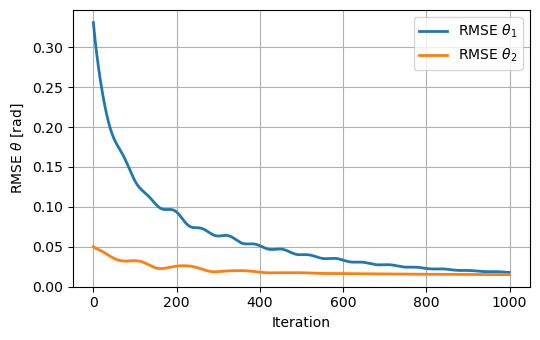

In [20]:
if cache_path.exists():
    print("Loading tau_eq_ts and P from cache...")
    cache_data = jnp.load(str(cache_path))
    tau_eq_ts, P = cache_data["tau_eq_ts"], cache_data["P"]

ilc_its = run_q_ilc(
    rp=rp,
    traj_ts=traj_ts,
    th_0=th_0,
    th_d_0=traj_ts["th_d_ts"][0],
    num_iterations=num_ilc_iterations,
    tau_eq_ts=tau_eq_ts,
    P=P,
    Q_lq=Q_lq,
    S_lq=S_lq,
    kp_fb=kp_fb,
    kd_fb=kd_fb,
    rp_perturbed=rp_perturbed,
)

# plot configuration-space ILC convergence
plot_configuration_space_ilc_convergence(
    traj_ts,
    ilc_its,
    show=True,
    filepath=str(outputs_dir / "task_2d-3_ilc_convergence.pdf"),
)

In [21]:
# animate the configuration-space evolution through the iterations
if not AUTOGRADING:
    ani_configuration_space = animate_configuration_space_trajectory_following_plot(
        traj_ts,
        ilc_its,
        max_num_animated_its=50,
        show=False,
        filepath=str(
            outputs_dir / "task_2d-3_ilc_configuration_space_trajectory_following.mp4"
        ),
    )
    display(HTML(ani_configuration_space.to_html5_video()))

In [22]:
# animate the configuration-space evolution through the iterations
if not AUTOGRADING:
    ani_operational_space = animate_operational_space_trajectory_following_plot(
        traj_ts,
        ilc_its,
        max_num_animated_its=50,
        show=False,
        filepath=str(
            outputs_dir / "task_2d-3_ilc_operational_space_trajectory_following.mp4"
        ),
    )
    display(HTML(ani_operational_space.to_html5_video()))

In [23]:
# animation the actuation sequence through the iterations
if not AUTOGRADING:
    ani_actuation = animate_actuation_plot(
        traj_ts,
        ilc_its,
        max_num_animated_its=50,
        show=False,
        filepath=str(outputs_dir / "task_2d-3_ilc_actuation.mp4"),
    )
    display(HTML(ani_actuation.to_html5_video()))

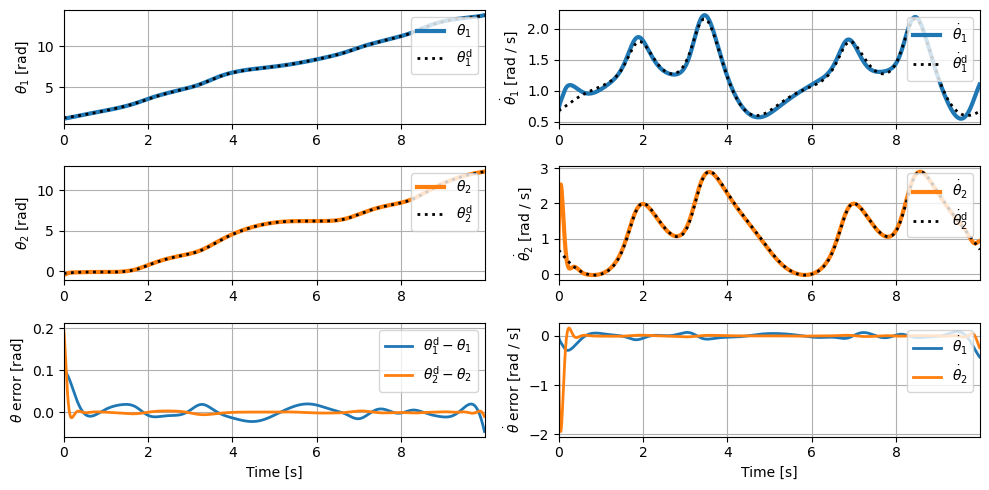

In [24]:
# import feedback controller from controllers.ipynb
from ipynb.fs.full.controllers import ctrl_fb_pd

# First, extract the feed-forward torques from the last ILC iteration.
# Then, simulate the system again using those torques and a PD feedback controller
# and save the system states to `sim_ts`.
# Hint: the feed-forward torques of shape (num_ilc_its, num_timesteps, 2) are accessible via
# `ilc_its["tau_ilc_its"]` and should be passed to the `tau_ext_ts` argument of the simulation method.
# YOUR CODE HERE
tau_ilc_ts = ilc_its["tau_ilc_its"][-1]

sim_ts = simulate_robot(
    rp=rp,
    t_ts=t_ts,
    th_0=th_0,
    th_d_0=traj_ts['th_d_ts'][0],
    tau_ext_ts=tau_ilc_ts,
    th_des_ts=traj_ts["th_ts"],
    th_d_des_ts=traj_ts["th_d_ts"],
    ctrl_fb=partial(ctrl_fb_pd, kp=kp_fb, kd=kd_fb),
)

# plot the configuration-space evolution
plot_configuration_space_trajectory_following(
    traj_ts,
    sim_ts,
    filepath=str(
        outputs_dir / "task_2d-3_configuration_space_trajectory_following.pdf"
    ),
)

In [25]:
rmse_th, rmse_th_d, rmse_th_dd = compute_configuration_space_rmse(traj_ts, sim_ts)
rmse_x, rmse_x_d, rmse_x_dd = compute_operational_space_rmse(traj_ts, sim_ts)
with jnp.printoptions(precision=3):
    print(
        "RMSE theta:",
        rmse_th,
        "rad, RMSE theta_d:",
        rmse_th_d,
        "rad/s, RMSE theta_dd:",
        rmse_th_dd,
        "rad/s^2",
    )
    print(
        "RMSE x:",
        f"{jnp.linalg.norm(rmse_x):.4f}",
        "m, RMSE x_d:",
        f"{jnp.linalg.norm(rmse_x_d):.3f}",
        "m/s, RMSE x_dd:",
        f"{jnp.linalg.norm(rmse_x_dd):.2f}",
        "m/s^2",
    )

RMSE theta: [0.018 0.015] rad, RMSE theta_d: [0.076 0.179] rad/s, RMSE theta_dd: [0.412 3.609] rad/s^2
RMSE x: 0.0398 m, RMSE x_d: 0.252 m/s, RMSE x_dd: 3.82 m/s^2


In [26]:
# DO NOT REMOVE OR MODIFY THIS CELL

assert (
    jnp.linalg.norm(rmse_x) < 0.04
)  # The end-effector error needs to be smaller than 0.04 m


In [27]:
# animate this simulation
if not AUTOGRADING:
    ani_robot = animate_robot(
        rp_perturbed,
        traj_ts=traj_ts,
        sim_ts=sim_ts,
        step_skip=5,
        show=False,
        filepath=str(outputs_dir / "task_2d-3_controlled_robot.mp4"),
    )
    display(HTML(ani_robot.to_html5_video()))